In [2]:
"""References:
    -https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
    -https://www.kaggle.com/ouerten2/used-car-price-prediction-with-neural-networks/output?fbclid=IwAR3-onxCEQl6CniPd3ZJRl6_6p4321BL1bEYFIbJcYBXVM-5Ti6Vdbk2ntA
"""


"""import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
train = pd.read_csv('data.csv')
test = pd.read_csv('data.csv')
display(train)"""

import os 
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing / input output file operations
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

data = pd.read_csv("autos.csv", encoding = "ISO-8859-1") # Reading data
display(data.head(4).transpose()) # to see the attributes
display(data.tail(3).transpose()) # to see the attributes

fields_to_check = ['dateCrawled','name','abtest','vehicleType','gearbox','model','fuelType','brand','notRepairedDamage','dateCreated','lastSeen']  


"""for attr in attributes:
    print("Attribute have {} null values '{}'.".format(len(data[data[attr]=='']),attr)) # Printing Null values
#display(data[data['price']<data.price.quantile(0.999)].price.describe()) 

display("There are {} records in the database suitable for processing.".format(len(data)))

price_data=data['MSRP'] # Transfer price to a new set
features_data=data.drop('MSRP',1) # Price subtracted from other table
"""

#Pre Processing

#fields to check
for field in fields_to_check:
    print("Attribute have {} null values '{}'.".format(len(data[data[field]=='']),field)) 
#print null values
    
display(data[data['price']<data.price.quantile(0.999)].price.describe())    
# because the number of pictures is the same in all advertisements.
input_data=data.drop('nrOfPictures',1)  
input_data=input_data[input_data['seller']=='privat']    
input_data=input_data[input_data['offerType']=='Angebot']
input_data=input_data.drop(['seller','offerType'],1) 
#private offers are removed because they are few

input_data=input_data[input_data['gearbox']!=''] 
input_data=input_data[input_data['vehicleType']!='']
input_data=input_data[input_data['fuelType']!='']
input_data=input_data[input_data['notRepairedDamage']!='']

model_set=set(input_data.model.str.upper())
#model_set.remove('')
input_data.name=input_data.name.str.upper()
input_data.name=input_data.name.str.split('_')
# Those that do not have a model name are assigned a name in the name field.
for index,row in input_data.iterrows():        
    if input_data.model[index]=='':
        for name_pcs in input_data.name[index]:
            if name_pcs in model_set:
                input_data.loc[index,'model']=name_pcs
                break
input_data=input_data[input_data['model']!='']
input_data.model=input_data.model.str.upper()
input_data.brand=input_data.brand.str.upper()
input_data=input_data.drop('name',1)  
#Name is dropped because it is not needed.
input_data=input_data[input_data['price']!=0]
input_data=input_data[(input_data.powerPS>0) & (input_data.powerPS<=1500)]
input_data=input_data[(input_data.yearOfRegistration>=1950) & (input_data.yearOfRegistration<2017)]
input_data=input_data[input_data['monthOfRegistration']!=0]
input_data=input_data[input_data.price<input_data.price.quantile(0.999)]    
#%1 top prices subtracted
# Date values are converted to string and then converted to numerical data.
input_data.dateCrawled=pd.to_datetime(input_data.dateCrawled)          
level_dateCrawled=input_data['dateCrawled'].min()-np.timedelta64(1,'D')
input_data.dateCrawled=(input_data['dateCrawled'] - level_dateCrawled)/np.timedelta64(1,'D')

input_data.dateCreated=pd.to_datetime(input_data.dateCreated)
level_dateCreated=input_data['dateCreated'].min()-np.timedelta64(1,'D')
input_data.dateCreated=(input_data['dateCreated'] - level_dateCreated)/np.timedelta64(1,'D')

input_data.lastSeen=pd.to_datetime(input_data.lastSeen)
level_lastSeen=input_data['lastSeen'].min()-np.timedelta64(1,'D')
input_data.lastSeen=(input_data['lastSeen'] - level_lastSeen)/np.timedelta64(1,'D')

input_data.postalCode=input_data.postalCode.apply(lambda x: str(int(x/1000))) 
#postal code is arranged to stay in the first 2 digits.
input_data.monthOfRegistration=input_data.monthOfRegistration.apply(lambda x: str(x))

display(input_data.head(3))
display(input_data.tail(3))
display("There are {} records available for processing in the database.".format(len(input_data)))
    
#Price is being transferred to a new set
price_data=input_data['price']  
#price subtracted from other table
features_data=input_data.drop('price',1)


scaler = MinMaxScaler()  
# It resizes to 0-1 for easier processing of data.
numerical = ['yearOfRegistration', 'powerPS', 'kilometer','dateCrawled','dateCreated','lastSeen']
features_data[numerical] = scaler.fit_transform(input_data[numerical])   
# Creating dummy variables for categorical data.
features_data = pd.get_dummies(features_data)  
encoded = list(features_data.columns) 
display("There are {} features after one hot encoding".format(len(encoded))) 
display(encoded)


"""# Split feature and income data into training and test sets
# Feature and price data are divided into 6: 2: 2 ratio as train test and validation.
X_train_val, X_test, y_train_val, y_test = train_test_split(features_data, price_data, test_size = 0.2, random_state = 0)
X_train,X_val,y_train,y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = 0)

display(features_data.head(3))
display(price_data.head(3))

# Show the results of the split
print("The train set has an example of {}.".format(X_train.shape[0]))
print("Validation set has an example of {}.".format(X_val.shape[0]))
print("The test set has an example of {}.".format(X_test.shape[0]))

# Lists are converted to numpy arrays.
X_train=np.array(X_train)
y_train=np.array(y_train)
X_val=np.array(X_val)
y_val=np.array(y_val)
X_test=np.array(X_test)
y_test=np.array(y_test)"""

X_train_val, X_test, y_train_val, y_test = train_test_split(features_data, price_data, test_size = 0.2, random_state = 0)
X_train,X_val,y_train,y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = 0)

display(features_data.head(3))

# Show the results of the split
print("The train set has an example of {}.".format(X_train.shape[0]))
print("Validation set has an example of {}.".format(X_val.shape[0]))
print("The test set has an example of {}.".format(X_test.shape[0]))

X_train=np.array(X_train) #lists are converted to numpy arrays
y_train=np.array(y_train)
X_val=np.array(X_val)
y_val=np.array(y_val)
X_test=np.array(X_test)
y_test=np.array(y_test)


,0,1,2,3
dateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04
name,Golf_3_1.6,A5_Sportback_2.7_Tdi,"Jeep_Grand_Cherokee_""Overland""",GOLF_4_1_4__3TÜRER
seller,privat,privat,privat,privat
offerType,Angebot,Angebot,Angebot,Angebot
price,480,18300,9800,1500
abtest,test,test,test,test
vehicleType,NaN,coupe,suv,kleinwagen
yearOfRegistration,1993,2011,2004,2001
gearbox,manuell,manuell,automatik,manuell
powerPS,0,190,163,75


,371525,371526,371527
dateCrawled,2016-03-19 18:57:12,2016-03-20 19:41:08,2016-03-07 19:39:19
name,Volkswagen_Multivan_T4_TDI_7DC_UY2,VW_Golf_Kombi_1_9l_TDI,BMW_M135i_vollausgestattet_NP_52.720____Euro
seller,privat,privat,privat
offerType,Angebot,Angebot,Angebot
price,9200,3400,28990
abtest,test,test,control
vehicleType,bus,kombi,limousine
yearOfRegistration,1996,2002,2013
gearbox,manuell,manuell,manuell
powerPS,102,100,320


Attribute have 0 null values 'dateCrawled'.
Attribute have 0 null values 'name'.
Attribute have 0 null values 'abtest'.
Attribute have 0 null values 'vehicleType'.
Attribute have 0 null values 'gearbox'.
Attribute have 0 null values 'model'.
Attribute have 0 null values 'fuelType'.
Attribute have 0 null values 'brand'.
Attribute have 0 null values 'notRepairedDamage'.
Attribute have 0 null values 'dateCreated'.
Attribute have 0 null values 'lastSeen'.


count    371156.000000
mean       5616.158338
std        7559.086800
min           0.000000
25%        1150.000000
50%        2950.000000
75%        7200.000000
max      108500.000000
Name: price, dtype: float64

,dateCrawled,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
1,19.869711,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,AUDI,ja,231.0,66,33.480347
2,9.948600,9800,test,suv,2004,automatik,163,GRAND,125000,8,diesel,JEEP,NaN,221.0,90,31.939329
3,13.116458,1500,test,kleinwagen,2001,manuell,75,GOLF,150000,6,benzin,VOLKSWAGEN,nein,224.0,91,13.142465


,dateCrawled,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
371525,15.201968,9200,test,bus,1996,manuell,102,TRANSPORTER,150000,3,diesel,VOLKSWAGEN,nein,226.0,87,33.708542
371526,16.232477,3400,test,kombi,2002,manuell,100,GOLF,150000,6,diesel,VOLKSWAGEN,NaN,227.0,40,19.937650
371527,3.231215,28990,control,limousine,2013,manuell,320,M_REIHE,50000,8,benzin,BMW,nein,214.0,73,17.543079


'There are 294645 records available for processing in the database.'

'There are 424 features after one hot encoding'

['dateCrawled',
 'yearOfRegistration',
 'powerPS',
 'kilometer',
 'dateCreated',
 'lastSeen',
 'abtest_control',
 'abtest_test',
 'vehicleType_andere',
 'vehicleType_bus',
 'vehicleType_cabrio',
 'vehicleType_coupe',
 'vehicleType_kleinwagen',
 'vehicleType_kombi',
 'vehicleType_limousine',
 'vehicleType_suv',
 'gearbox_automatik',
 'gearbox_manuell',
 'model_100',
 'model_145',
 'model_147',
 'model_156',
 'model_159',
 'model_1ER',
 'model_1_REIHE',
 'model_200',
 'model_2_REIHE',
 'model_300C',
 'model_3ER',
 'model_3_REIHE',
 'model_4_REIHE',
 'model_500',
 'model_5ER',
 'model_5_REIHE',
 'model_601',
 'model_6ER',
 'model_6_REIHE',
 'model_7ER',
 'model_80',
 'model_850',
 'model_90',
 'model_900',
 'model_9000',
 'model_911',
 'model_A1',
 'model_A2',
 'model_A3',
 'model_A4',
 'model_A5',
 'model_A6',
 'model_A8',
 'model_ACCORD',
 'model_AGILA',
 'model_ALHAMBRA',
 'model_ALMERA',
 'model_ALTEA',
 'model_AMAROK',
 'model_ANDERE',
 'model_ANTARA',
 'model_AROSA',
 'model_ASTRA',

,dateCrawled,yearOfRegistration,powerPS,kilometer,dateCreated,lastSeen,abtest_control,abtest_test,vehicleType_andere,vehicleType_bus,...,postalCode_90,postalCode_91,postalCode_92,postalCode_93,postalCode_94,postalCode_95,postalCode_96,postalCode_97,postalCode_98,postalCode_99
1,0.571441,0.924242,0.126084,0.827586,0.942623,0.983348,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.270995,0.818182,0.108072,0.827586,0.901639,0.936694,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0.366929,0.772727,0.049366,1.000000,0.913934,0.367615,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


The train set has an example of 176787.
Validation set has an example of 58929.
The test set has an example of 58929.


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, Callback
from keras import backend
#from tensorflow.keras import backend

# Lost function is selected as mean absolute error
loss_function='mean_absolute_error'
# The sequential model is created to use compile-fit-evaluate-predict methods
price_predictor = Sequential()
# Neural network layers are created with RELU activation
price_predictor.add(Dense(128,activation='relu', input_dim=424))  
price_predictor.add(Dense(64))
price_predictor.add(Dense(32,activation='relu'))
price_predictor.add(Dense(8))
price_predictor.add(Dense(1))
price_predictor.summary()

# Here the Adam optimizer (different type of stochastic gradient descent) is used.
price_predictor.compile(optimizer='Adam', loss=loss_function)

# It allows new callbacks by abstracting the base class.
checkpointer = ModelCheckpoint(filepath='price_prediction.hdf5', verbose=1, save_best_only=True)

# Trains the model according to the number of epoch given.
#price_predictor.fit(X_train, y_train, validation_data=[X_val,y_val], epochs=20, batch_size=500, callbacks=[checkpointer], verbose=0) 
price_predictor.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=500, callbacks=[checkpointer], verbose=0)

price_predictor.load_weights('price_prediction.hdf5')
score=price_predictor.evaluate(X_test,y_test,verbose=1)
display("The final model scores {} for test data.".format(score))

price_prediction=price_predictor.predict(X_test)

"""model = Sequential([
    Dense(85, activation='relu', input_shape=(1079,)),
    Dense(85, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(X_train, y_train,
          batch_size=32, epochs=10,
          validation_data=(X_val, y_val))"""





Using TensorFlow backend.





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               54400     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 65,009
Trainable params: 65,009
Non-trainable params: 0
_________________________________________________________________




Epoch 00001: val_loss improved from inf to 3304.03331, saving model to price_prediction.hdf5

Epoch 00002: val_loss improved from 3

'The final model scores 1368.706356781953 for test data.'

"model = Sequential([\n    Dense(85, activation='relu', input_shape=(1079,)),\n    Dense(85, activation='relu'),\n    Dense(1, activation='sigmoid'),\n])\n\nmodel.compile(optimizer='sgd',\n              loss='binary_crossentropy',\n              metrics=['accuracy'])\n\n\nmodel.fit(X_train, y_train,\n          batch_size=32, epochs=10,\n          validation_data=(X_val, y_val))"

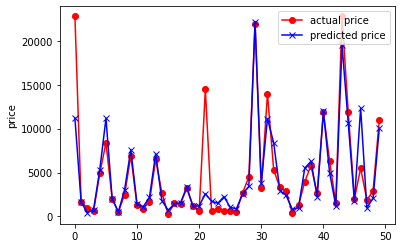

In [4]:
num_samples=50
idx=random.sample(range(len(y_test)),num_samples) 
plt.plot(range(num_samples),y_test[idx],'ro-')
plt.plot(range(num_samples),price_prediction[idx],'bx-')
plt.ylabel("price")
plt.legend(["actual price",'predicted price','mean price'])